# ta-lib-008 ( Feature‑Engineering + Sequence Models)
https://chatgpt.com/c/680d231a-52f4-800a-a105-9f5bfe49fca1

What's new:

1- Add EarlyStopping

In [3]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks


In [4]:
# PARAMETERS
DATA_PATH = '../datasets/XAGUSD-H1-rates.csv'   # Path to your historical Forex data CSV
MODEL_SAVE_PATH = 'lstm_forex_model.h5'
WINDOW_SIZE = 30              # Number of past candles used as input
FORECAST_HORIZON = 10         # Number of future candles to predict
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
TEST_SIZE = 0.2               # % of data for validation
TARGET_COLUMN = '<CLOSE>'       # Which price to predict: '<CLOSE>', 'open', etc.

In [5]:
# Load your historical Forex data
df = pd.read_csv(DATA_PATH, sep='\t')

# Basic cleaning if necessary
df = df.dropna()
df.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2015.01.02,09:00:00,15.889,15.896,15.807,15.834,993,18451000,21
1,2015.01.02,10:00:00,15.836,15.864,15.822,15.834,1116,25764000,22
2,2015.01.02,11:00:00,15.836,15.838,15.790,15.822,1023,18885000,19
3,2015.01.02,12:00:00,15.827,15.828,15.725,15.772,1286,23593000,21
4,2015.01.02,13:00:00,15.781,15.786,15.667,15.734,1584,28750000,17


In [6]:
# Feature Engineering (TA-Lib indicators)
def add_ta_features(df):
    df['rsi'] = talib.RSI(df['<CLOSE>'], timeperiod=14)
    df['macd'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['<CLOSE>'])
    df['ema_10'] = talib.EMA(df['<CLOSE>'], timeperiod=10)
    df['ema_50'] = talib.EMA(df['<CLOSE>'], timeperiod=50)
    df['atr'] = talib.ATR(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df['adx'] = talib.ADX(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df = df.dropna()
    return df


df = add_ta_features(df)
df.head()


,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>,rsi,macd,MACD_signal,MACD_hist,ema_10,ema_50,atr,adx
49,2015.01.06,11:00:00,16.335,16.363,16.291,16.337,1619,27298000,14,63.967811,0.090198,0.085270,0.004928,16.245239,15.994400,0.093989,25.032045
50,2015.01.06,12:00:00,16.339,16.339,16.267,16.280,935,17768000,19,59.030236,0.087423,0.085701,0.001722,16.251559,16.005600,0.092418,25.807159
51,2015.01.06,13:00:00,16.282,16.293,16.207,16.218,996,21705000,20,54.135432,0.079307,0.084422,-0.005115,16.245458,16.013929,0.091960,25.448281
52,2015.01.06,14:00:00,16.218,16.270,16.188,16.245,1055,21843000,18,55.852257,0.074198,0.082377,-0.008179,16.245374,16.022991,0.091248,24.800014
53,2015.01.06,15:00:00,16.249,16.336,16.187,16.242,1910,43189000,15,55.603205,0.069111,0.079724,-0.010613,16.244761,16.031580,0.095373,24.915935


In [7]:
# Scaling Features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', 'rsi', 'macd', 'ema_10', 'ema_50', 'atr', 'adx']])

In [8]:


def create_sequences(features, target, window_size, forecast_horizon):
    X, y = [], []
    for i in range(window_size, len(features) - forecast_horizon):
        X.append(features[i-window_size:i])
        y.append(target[i:i+forecast_horizon])
    return np.array(X), np.array(y)

# Prepare data
target_data = df[TARGET_COLUMN].values
X, y = create_sequences(scaled_features, target_data, WINDOW_SIZE, FORECAST_HORIZON)

print(f'Input shape: {X.shape}')
print(f'Target shape: {y.shape}')


Input shape: (54994, 30, 11)
Target shape: (54994, 10)


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (43995, 30, 11) (43995, 10)
Test : (10999, 30, 11) (10999, 10)


In [10]:
def build_model(input_shape, forecast_horizon, learning_rate):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(forecast_horizon)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

model = build_model((X_train.shape[1], X_train.shape[2]), FORECAST_HORIZON, LEARNING_RATE)
model.summary()


/home/saeed/repozitories/machine-learning/tensorflow-course/start-tensorflow/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,202 (125.79 KB)

 Trainable params: 32,202 (125.79 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training model
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50


2025-04-27 14:19:21.831829: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58073400 exceeds 10% of free system memory.


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - loss: 122.8825 - val_loss: 23.4427
Epoch 2/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 13.6861 - val_loss: 0.8058
Epoch 3/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - loss: 3.6701 - val_loss: 0.4019
Epoch 4/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 2.9318 - val_loss: 0.2266
Epoch 5/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - loss: 2.6884 - val_loss: 0.1081
Epoch 6/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - loss: 2.5986 - val_loss: 0.4507
Epoch 7/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - loss: 2.4275 - val_loss: 0.1574
Epoch 8/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - loss: 2.2895 - val_loss: 0.0910
Epoch 9/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - loss: 2.1384 - val_loss: 0.0809
Epoch 10/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - loss: 2.0378 - val_loss: 0.1028
Epoch 11/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 1.9466 - val_loss: 0.0715
Epoch 12/50
137

In [12]:
# Predict
y_pred = model.predict(X_test)

# Inverse Scaling (Optional, if needed)
# Example if you had scaled target separately, here we skipped that


344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


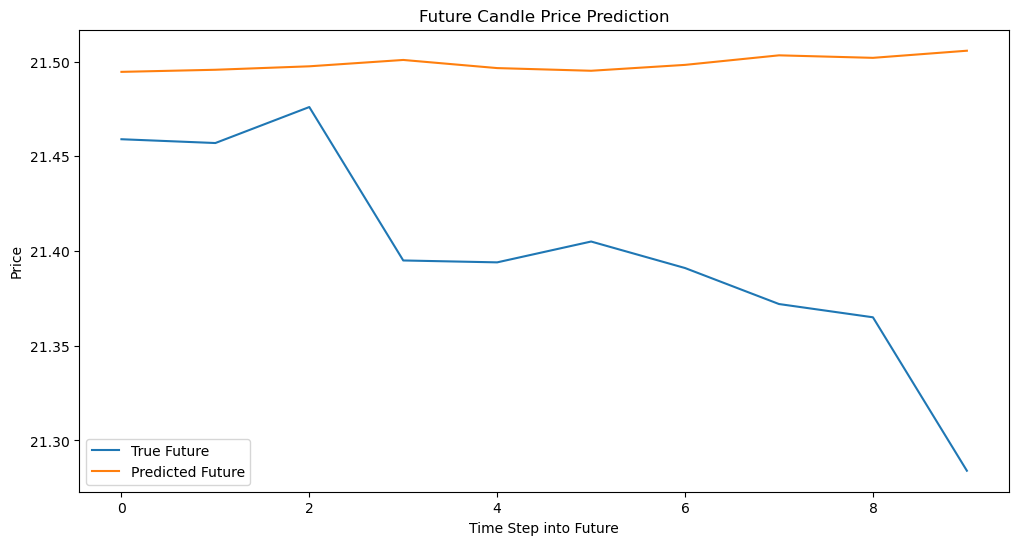

In [15]:
# Plot first prediction vs true future prices
plt.figure(figsize=(12,6))
plt.plot(range(FORECAST_HORIZON), y_test[0], label='True Future')
plt.plot(range(FORECAST_HORIZON), y_pred[0], label='Predicted Future')
plt.title('Future Candle Price Prediction')
plt.xlabel('Time Step into Future')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")
